In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

C:\Users\DELL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(array([   7.,   53.,  302.,  610., 5553.,  208.,  179.,   43.,   18.,
          11.]),
 array([-0.9197341 , -0.72776069, -0.53578728, -0.34381387, -0.15184046,
         0.04013295,  0.23210636,  0.42407977,  0.61605318,  0.80802659,
         1.        ]),
 <a list of 10 Patch objects>)

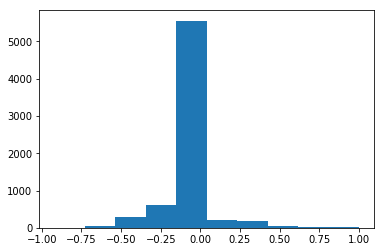

In [2]:
# Thư mục để dữ liệu
data_dir = 'dataset'
# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
X = data_df[['center', 'left', 'right']].values
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

Do quá nhiều dữ liệu với góc lái ở 0 tức là để ô tô đi thẳng, nên ta sẽ loại bỏ bớt đi để tránh việc model có xu hướng dự đoán góc lái thiên về 0.

(array([   7.,   53.,  302.,  610., 1503.,  208.,  179.,   43.,   18.,
          11.]),
 array([-0.9197341 , -0.72776069, -0.53578728, -0.34381387, -0.15184046,
         0.04013295,  0.23210636,  0.42407977,  0.61605318,  0.80802659,
         1.        ]),
 <a list of 10 Patch objects>)

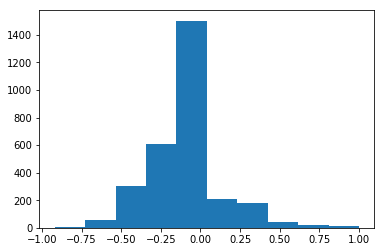

In [3]:
# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

Ta vẫn để giá trị góc lái ở 0 là nhiều nhất vì có thể phần nhiều thời gian của ô tô là đi thẳng thật. Việc histogram lệch bên trái không quá quan trọng vì ta dùng flip ảnh.

In [4]:
# Chia ra traing set và validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# Xây dựng model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
__________

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu

In [7]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    max_q_size=1,
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    nb_val_samples=len(X_valid),
                    callbacks=[checkpoint],
                    verbose=1)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1000, epochs=10, validation_data=<generator..., callbacks=[<keras.ca..., verbose=1, validation_steps=587, max_queue_size=1)`


Epoch 1/10
1000/1000 [==============================] - 100s 100ms/step - loss: 0.0631 - val_loss: 0.0332
Epoch 2/10
1000/1000 [==============================] - 102s 102ms/step - loss: 0.0500 - val_loss: 0.0305
Epoch 3/10
1000/1000 [==============================] - 100s 100ms/step - loss: 0.0468 - val_loss: 0.0332
Epoch 4/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0452 - val_loss: 0.0304
Epoch 5/10
1000/1000 [==============================] - 95s 95ms/step - loss: 0.0433 - val_loss: 0.0293
Epoch 6/10
1000/1000 [==============================] - 95s 95ms/step - loss: 0.0421 - val_loss: 0.0305
Epoch 7/10
1000/1000 [==============================] - 95s 95ms/step - loss: 0.0409 - val_loss: 0.0298
Epoch 8/10
1000/1000 [==============================] - 101s 101ms/step - loss: 0.0403 - val_loss: 0.0293
Epoch 9/10
1000/1000 [==============================] - 98s 98ms/step - loss: 0.0390 - val_loss: 0.0303
Epoch 10/10
1000/1000 [==============================] -

Vậy model ở epoch 8 có val_loss thấp nhất nên ta sẽ dùng model này để cho ô tô tự lái